In [1]:
from deepmol.pipeline import Pipeline

from deepmol.scalers import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from deepmol.models import SklearnModel
from deepmol.compound_featurization import MorganFingerprint, TwoDimensionDescriptors, LayeredFingerprint
from deepmol.standardizer import ChEMBLStandardizer
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

steps = [
         ('morgan fingerprints', MorganFingerprint(radius=2, size=1024, n_jobs=10)),
         ('random forest', SklearnModel(model=RidgeClassifier(random_state=42)))
         ]
pipeline_morgan_fp = Pipeline(steps=steps, path="morgan_fp")

pipeline_layered_fingerprints_baseline_ridge_classifier = Pipeline(steps=[('layered fingerprints', LayeredFingerprint()),
                                                                           ('ridge classifier', SklearnModel(model=RidgeClassifier(random_state=42)))])



2024-03-08 11:02:04.239444: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 11:02:04.284198: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 11:02:04.284247: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 11:02:04.284280: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 11:02:04.292712: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-08 11:02:04.293383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
from deepmol.loaders import CSVLoader
import numpy as np

train = CSVLoader("training_set_overlapping.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

for column in range(train.y.shape[1]):
    if len(np.unique(train.y[:, column])) == 1:
        print(column)

2024-03-08 11:02:08,546 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


In [3]:
from deepmol.loaders import CSVLoader
import numpy as np


def fit_and_evaluate(pipeline):
    train = CSVLoader("training_set_overlapping.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("overlapping_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    pipeline.fit(train)
    from sklearn.metrics import f1_score, precision_score, recall_score
    from deepmol.metrics import Metric
    
    columns_to_remove = []
    for i in range(test.y.shape[1]):
        if np.sum(test.y[:, i]) == 0:
            columns_to_remove.append(i)
    

    predictions = pipeline.predict(test)
    f1_scores = []
    recall_scores = []
    precision_scores = []
    test = pipeline.transform(test)

    y_true = test.y
    y_true = np.delete(y_true, columns_to_remove, axis=1)
    y_pred = predictions
    y_pred = np.delete(y_pred, columns_to_remove, axis=1)

    for i in range(y_pred.shape[1]):
        f1_score_task = f1_score(y_true[:, i], y_pred[:, i])
        recall_score_task = recall_score(y_true[:, i], y_pred[:, i])
        precision_score_task = precision_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1_score_task)
        recall_scores.append(recall_score_task)
        precision_scores.append(precision_score_task)
    
    results_test = [{}]
    results_test[0]['f1_scores_std'] = np.array(f1_scores).std()
    results_test[0]['recall_scores_std'] = np.array(recall_scores).std()
    results_test[0]['precision_scores_std'] = np.array(precision_scores).std()
    results_test[0]['macro_f1_score'] = np.array(f1_scores).mean()
    results_test[0]['macro_recall_score'] = np.array(recall_scores).mean()
    results_test[0]['macro_precision_score'] = np.array(precision_scores).mean()

    return results_test

In [4]:
from deepmol.pipeline import Pipeline

pipeline_285 = Pipeline.load('../sm_predictor_pipeline_tpe_sklearn/trial_285')

print("Morgan FP")
results_pipeline_morgan_fp = fit_and_evaluate(pipeline_morgan_fp)
print("Layered FP and Ridge Classifier")
results_pipeline_layered_fingerprints_baseline_ridge_classifier = fit_and_evaluate(pipeline_layered_fingerprints_baseline_ridge_classifier)
print("Layered FP and Ridge Classifier (optimized)")
results_pipeline_285 = fit_and_evaluate(pipeline_285)

Morgan FP
2024-03-08 11:02:08,796 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:02:08,833 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layered FP and Ridge Classifier
2024-03-08 11:02:11,184 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:02:11,219 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layered FP and Ridge Classifier (optimized)
2024-03-08 11:02:16,585 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:02:16,617 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

In [5]:
color_map = {'Layered FP + Low Variance FS + Ridge Classifier': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Layered FP + Ridge Classifier': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'Morgan FP + Ridge Classifier': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'Morgan FP + MLP': (0.8352941176470589, 0.3686274509803922, 0.0),
 'MGCNN (Eguchi et al. 2019)': (0.8, 0.47058823529411764, 0.7372549019607844),
 'Morgan FP + Random Forest': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'Morgan FP + KNN': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'Descriptors + Random Forest': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451) }

In [6]:
import pandas as pd

results_mgcnn = pd.read_csv("results_overlapping.csv")
results_mgcnn.fillna(0, inplace=True)
pipeline_mgcnn_results = [results_mgcnn["f1_score"].mean(), results_mgcnn["precision"].mean(), results_mgcnn["recall"].mean()]
pipeline_mgcnn_results

[0.5437646410917689, 0.605084860230209, 0.5949724735961437]

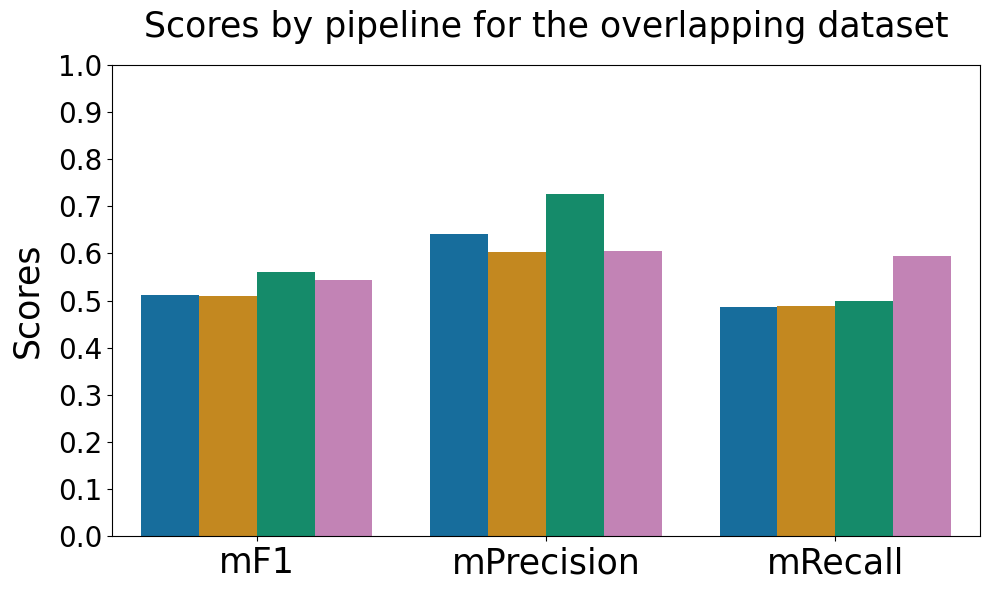

In [7]:
# plot the results of the three pipelines
import matplotlib.pyplot as plt
import numpy as np

labels = ['macro_f1_score', 'macro_precision_score', 'macro_recall_score']
pipeline_285_results = [results_pipeline_285[0]['macro_f1_score'], results_pipeline_285[0]['macro_precision_score'], results_pipeline_285[0]['macro_recall_score']]
pipeline_morgan_fp_results = [results_pipeline_morgan_fp[0]['macro_f1_score'], results_pipeline_morgan_fp[0]['macro_precision_score'], results_pipeline_morgan_fp[0]['macro_recall_score']]
pipeline_layered_fingerprints_baseline_ridge_classifier_results = [results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['macro_f1_score'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['macro_precision_score'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['macro_recall_score']]

pipeline_285_std = [results_pipeline_285[0]['f1_scores_std'], results_pipeline_285[0]['precision_scores_std'], results_pipeline_285[0]['recall_scores_std']]
pipeline_morgan_fp_std = [results_pipeline_morgan_fp[0]['f1_scores_std'], results_pipeline_morgan_fp[0]['precision_scores_std'], results_pipeline_morgan_fp[0]['recall_scores_std']]
pipeline_layered_fingerprints_baseline_ridge_classifier_std = [results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['f1_scores_std'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['precision_scores_std'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['recall_scores_std']]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['savefig.transparent'] = True
# Sample data setup (replace with your actual data)
# Assuming you have your pipeline results as separate lists like before
# Here's how you might structure them into a DataFrame:

data = {
    "Label": labels * 4,  # Repeat 'labels' for each pipeline
    "Scores": np.concatenate([
        pipeline_285_results,
        pipeline_layered_fingerprints_baseline_ridge_classifier_results,
        pipeline_morgan_fp_results,
        pipeline_mgcnn_results,
    ]),
    "Pipeline": (
        ["Layered FP + Low Variance FS + Ridge Classifier"] * len(labels) +
        ["Layered FP + Ridge Classifier"] * len(labels) +
        ["Morgan FP + Ridge Classifier"] * len(labels) +
        ["MGCNN (Eguchi et al. 2019)"] * len(labels)
    )
}

df = pd.DataFrame(data)
#df.sort_values(by="Scores", ascending=False, inplace=True)  # Sort by scores for better visualization

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
barplot = sns.barplot(data=df, x="Label", y="Scores", hue="Pipeline", dodge=True, palette=color_map, legend=False)

# for i, p in enumerate(barplot.patches):
#     # Calculate annotation text position
#     if p.get_height() != 0:
        # x = p.get_x() + p.get_width() / 2
        # # Get the corresponding standard deviation from the DataFrame
        # std = df.loc[i % len(df), 'STD']  # Adjust index for std
        # # Add error bar for this bar using plt.errorbar
        # plt.errorbar(x, p.get_height(), yerr=std, fmt='none', capsize=5, color='black')

        # barplot.annotate(format(p.get_height(), '.3f'),  # Text to display
        #                 (p.get_x() + p.get_width() / 2., p.get_height() + 0.05),  # Position
        #                 ha='center', va='center',  # Center alignment
        #                 xytext=(0, 9),  # Distance from the top of the bar
        #                 textcoords='offset points',
        #                 rotation=90)  # Text rotation (90 degrees)

plt.title('Scores by pipeline for the overlapping dataset', pad=20, size=25)  # Adjust title position
plt.ylabel('Scores', labelpad=10, size=25)  # Adjust y-axis label position
plt.xlabel('', labelpad=10, size=25)
# define other names for the ticks
plt.xticks([0, 1, 2], ['mF1', 'mPrecision', 'mRecall'], size=25)

#plt.legend(title='Pipeline', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size=20)

plt.tight_layout()  # Adjust layout
plt.savefig("overlapping_dataset_results.png", dpi=400)

In [27]:
from deepmol.loaders import CSVLoader
import numpy as np


def fit_and_evaluate(pipeline, pipeline_name):
    train = CSVLoader("training_set_overlapping.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("overlapping_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    pipeline.fit(train)
    from sklearn.metrics import f1_score, precision_score, recall_score
    from deepmol.metrics import Metric
    
    columns_to_remove = []
    for i in range(test.y.shape[1]):
        if np.sum(test.y[:, i]) == 0:
            columns_to_remove.append(i)
    

    predictions = pipeline.predict(test)
    f1_scores = []
    recall_scores = []
    precision_scores = []
    test = pipeline.transform(test)

    y_true = test.y
    y_true = np.delete(y_true, columns_to_remove, axis=1)
    y_pred = predictions
    y_pred = np.delete(y_pred, columns_to_remove, axis=1)
    tasks = []
    for i in range(y_pred.shape[1]):
        f1_score_task = f1_score(y_true[:, i], y_pred[:, i])
        recall_score_task = recall_score(y_true[:, i], y_pred[:, i])
        precision_score_task = precision_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1_score_task)
        recall_scores.append(recall_score_task)
        precision_scores.append(precision_score_task)
        tasks.append(i)
    
    results_test = pd.DataFrame({'task': tasks, 'f1_score': f1_scores, 'precision': precision_scores, 'recall': recall_scores, 'pipeline': [pipeline_name]*len(f1_scores)})

    return results_test

In [28]:
pipeline_names = ["Layered FP + Low Variance FS + Ridge Classifier", "Layered FP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)"]

import pandas as pd
results = pd.DataFrame()
for pipeline, name in zip([pipeline_layered_fingerprints_baseline_ridge_classifier, pipeline_285, pipeline_morgan_fp], pipeline_names):
    print(name)
    results_ = fit_and_evaluate(pipeline, name)
    results = pd.concat([results, results_], axis=0)

Layered FP + Low Variance FS + Ridge Classifier
2024-03-08 11:04:58,009 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:04:58,045 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layered FP + Ridge Classifier
2024-03-08 11:05:05,722 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:05:05,757 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

Morgan FP + Ridge Classifier
2024-03-08 11:05:13,139 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:05:13,171 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
import pandas as pd

results_mgcnn = pd.read_csv("results_overlapping.csv")
results_mgcnn.fillna(0, inplace=True)

f1_scores = []
precision_scores = []
recall_scores = []
tasks = []

for i in range(results_mgcnn.shape[0]):
    f1_scores.append(results_mgcnn["f1_score"][i])
    precision_scores.append(results_mgcnn["precision"][i])
    recall_scores.append(results_mgcnn["recall"][i])
    tasks.append(i)

results_mgcnn = pd.DataFrame({'task': tasks, 'f1_score': f1_scores, 'precision': precision_scores, 'recall': recall_scores, 'pipeline': ["MGCNN (Eguchi et al. 2019)"]*len(f1_scores)})
results = pd.concat([results, results_mgcnn], axis=0)

In [32]:
pipeline_names = results['pipeline'].unique()
for pipeline in pipeline_names:
    print(pipeline)
    print("F1 score:", (results[results['pipeline'] == pipeline]['f1_score'].mean(), results[results['pipeline'] == pipeline]['f1_score'].std()))
    print("Precision:", (results[results['pipeline'] == pipeline]['precision'].mean(), results[results['pipeline'] == pipeline]['precision'].std()))
    print("Recall:", (results[results['pipeline'] == pipeline]['recall'].mean(), results[results['pipeline'] == pipeline]['recall'].std()))

Layered FP + Low Variance FS + Ridge Classifier
F1 score: (0.508585594504307, 0.41945053381029346)
Precision: (0.6033113608669727, 0.45536050174497344)
Recall: (0.48884273970710146, 0.4137837949821511)
Layered FP + Ridge Classifier
F1 score: (0.5120001327056052, 0.423045133782092)
Precision: (0.6420921985815603, 0.4669320962183981)
Recall: (0.48560951459887625, 0.42296369983124366)
Morgan FP + Ridge Classifier
F1 score: (0.5596574187231188, 0.3641630451044442)
Precision: (0.7267246240601504, 0.40679499943455005)
Recall: (0.4997693308464585, 0.3747488595550486)
MGCNN (Eguchi et al. 2019)
F1 score: (0.5437646410917689, 0.3551322083456117)
Precision: (0.605084860230209, 0.4025649335323634)
Recall: (0.5949724735961437, 0.3819275050668797)


In [12]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['pipeline'] == pipeline1)]['f1_score']
    f1_scores2 = results[(results['pipeline'] == pipeline2)]['f1_score']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [13]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['pipeline'] == pipeline1)]['recall']
    f1_scores2 = results[(results['pipeline'] == pipeline2)]['recall']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


In [14]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['pipeline'] == pipeline1)]['precision']
    f1_scores2 = results[(results['pipeline'] == pipeline2)]['precision']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


Significant difference between Layered FP + Low Variance FS + Ridge Classifier and Morgan FP + Ridge Classifier with p-value 0.0499499764547464


# Clustering dataset

In [15]:
from deepmol.loaders import CSVLoader
import numpy as np

train = CSVLoader("training_set_clustered.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

for column in range(train.y.shape[1]):
    if len(np.unique(train.y[:, column])) == 1:
        print(train.label_names[column])

2024-03-08 11:02:39,304 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


In [16]:
from deepmol.loaders import CSVLoader
import numpy as np


def fit_and_evaluate(pipeline):
    train = CSVLoader("training_set_clustered.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("clustered_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    pipeline.fit(train)
    from sklearn.metrics import f1_score, precision_score, recall_score
    from deepmol.metrics import Metric
    
    columns_to_remove = []
    for i in range(test.y.shape[1]):
        if np.sum(test.y[:, i]) == 0:
            columns_to_remove.append(i)
    

    predictions = pipeline.predict(test)
    f1_scores = []
    recall_scores = []
    precision_scores = []
    test = pipeline.transform(test)

    y_true = test.y
    y_true = np.delete(y_true, columns_to_remove, axis=1)
    y_pred = predictions
    y_pred = np.delete(y_pred, columns_to_remove, axis=1)

    for i in range(y_pred.shape[1]):
        f1_score_task = f1_score(y_true[:, i], y_pred[:, i])
        recall_score_task = recall_score(y_true[:, i], y_pred[:, i])
        precision_score_task = precision_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1_score_task)
        recall_scores.append(recall_score_task)
        precision_scores.append(precision_score_task)
    
    results_test = [{}]
    results_test[0]['f1_scores_std'] = np.array(f1_scores).std()
    results_test[0]['recall_scores_std'] = np.array(recall_scores).std()
    results_test[0]['precision_scores_std'] = np.array(precision_scores).std()
    results_test[0]['macro_f1_score'] = np.array(f1_scores).mean()
    results_test[0]['macro_recall_score'] = np.array(recall_scores).mean()
    results_test[0]['macro_precision_score'] = np.array(precision_scores).mean()

    return results_test

In [17]:
from deepmol.pipeline import Pipeline

pipeline_285 = Pipeline.load('../sm_predictor_pipeline_tpe_sklearn/trial_285')

print("Morgan FP")
results_pipeline_morgan_fp = fit_and_evaluate(pipeline_morgan_fp)
print("Layered FP and Ridge Classifier")
results_pipeline_layered_fingerprints_baseline_ridge_classifier = fit_and_evaluate(pipeline_layered_fingerprints_baseline_ridge_classifier)
print("Layered FP and Ridge Classifier (optimized)")
results_pipeline_285 = fit_and_evaluate(pipeline_285)

Morgan FP
2024-03-08 11:02:39,558 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:02:39,613 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layered FP and Ridge Classifier
2024-03-08 11:02:41,865 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:02:41,917 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layered FP and Ridge Classifier (optimized)
2024-03-08 11:02:48,602 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:02:48,658 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
import pandas as pd

results_mgcnn = pd.read_csv("mgcnn_results_clustered.csv")
results_mgcnn.fillna(0, inplace=True)
pipeline_mgcnn_results = [results_mgcnn["f1_score"].mean(), results_mgcnn["precision"].mean(), results_mgcnn["recall"].mean()]
pipeline_mgcnn_results

[0.4962027497203994, 0.49823149336777156, 0.5944426643944623]

In [19]:
color_map = {'Layered FP + Low Variance FS + Ridge Classifier': (0.00392156862745098,
  0.45098039215686275,
  0.6980392156862745),
 'Layered FP + Ridge Classifier': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'Morgan FP + Ridge Classifier': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'Morgan FP + MLP': (0.8352941176470589, 0.3686274509803922, 0.0),
 'MGCNN (Eguchi et al. 2019)': (0.8, 0.47058823529411764, 0.7372549019607844),
 'Morgan FP + Random Forest': (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 'Morgan FP + KNN': (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 'Descriptors + Random Forest': (0.5803921568627451, 0.5803921568627451, 0.5803921568627451) }

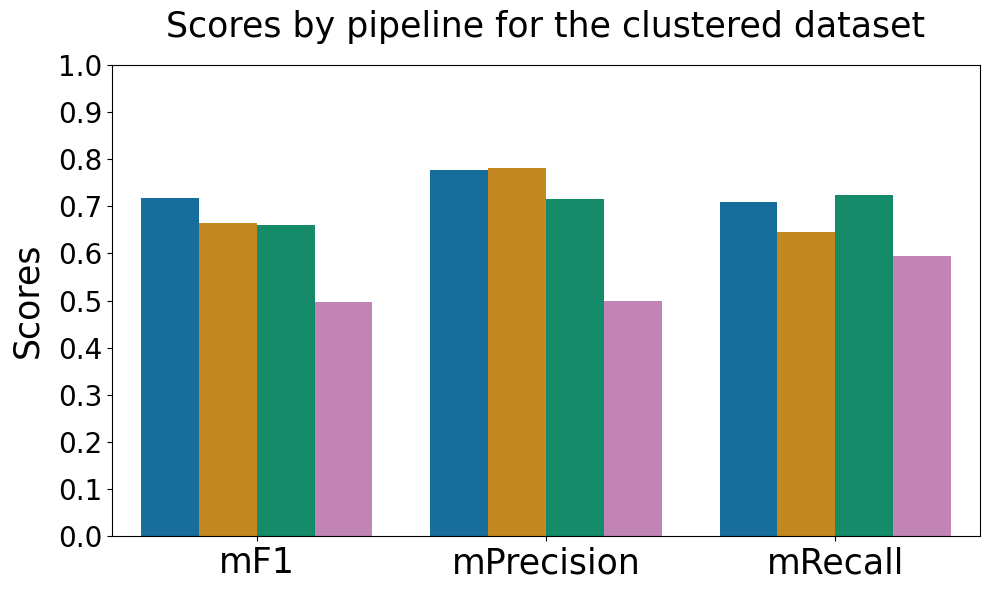

In [20]:
# plot the results of the three pipelines
import matplotlib.pyplot as plt
import numpy as np

labels = ['macro_f1_score', 'macro_precision_score', 'macro_recall_score']
pipeline_285_results = [results_pipeline_285[0]['macro_f1_score'], results_pipeline_285[0]['macro_precision_score'], results_pipeline_285[0]['macro_recall_score']]
pipeline_morgan_fp_results = [results_pipeline_morgan_fp[0]['macro_f1_score'], results_pipeline_morgan_fp[0]['macro_precision_score'], results_pipeline_morgan_fp[0]['macro_recall_score']]
pipeline_layered_fingerprints_baseline_ridge_classifier_results = [results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['macro_f1_score'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['macro_precision_score'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['macro_recall_score']]

pipeline_285_std = [results_pipeline_285[0]['f1_scores_std'], results_pipeline_285[0]['precision_scores_std'], results_pipeline_285[0]['recall_scores_std']]
pipeline_morgan_fp_std = [results_pipeline_morgan_fp[0]['f1_scores_std'], results_pipeline_morgan_fp[0]['precision_scores_std'], results_pipeline_morgan_fp[0]['recall_scores_std']]
pipeline_layered_fingerprints_baseline_ridge_classifier_std = [results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['f1_scores_std'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['precision_scores_std'], results_pipeline_layered_fingerprints_baseline_ridge_classifier[0]['recall_scores_std']]
pipeline_mgcnn_results_std = [results_mgcnn["f1_score"].std(), results_mgcnn["precision"].std(), results_mgcnn["recall"].std()]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['savefig.transparent'] = True

# Sample data setup (replace with your actual data)
# Assuming you have your pipeline results as separate lists like before
# Here's how you might structure them into a DataFrame:

data = {
    "Label": labels * 4,  # Repeat 'labels' for each pipeline
    "Scores": np.concatenate([
        pipeline_285_results,
        pipeline_layered_fingerprints_baseline_ridge_classifier_results,
        pipeline_morgan_fp_results,
        pipeline_mgcnn_results,
    ]),
    "Pipeline": (
        ["Layered FP + Low Variance FS + Ridge Classifier"] * len(labels) +
        ["Layered FP + Ridge Classifier"] * len(labels) +
        ["Morgan FP + Ridge Classifier"] * len(labels) +
         ["MGCNN (Eguchi et al. 2019)"] * len(labels)
    )
}

df = pd.DataFrame(data)
#df.sort_values(by="Scores", ascending=False, inplace=True)  # Sort by scores for better visualization

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
barplot = sns.barplot(data=df, x="Label", y="Scores", hue="Pipeline", dodge=True, palette=color_map, legend=False)

# for i, p in enumerate(barplot.patches):
#     # Calculate annotation text position
#     if p.get_height() != 0:
        # x = p.get_x() + p.get_width() / 2
        # # Get the corresponding standard deviation from the DataFrame
        # std = df.loc[i % len(df), 'STD']  # Adjust index for std
        # # Add error bar for this bar using plt.errorbar
        # plt.errorbar(x, p.get_height(), yerr=std, fmt='none', capsize=5, color='black')

        # barplot.annotate(format(p.get_height(), '.3f'),  # Text to display
        #                 (p.get_x() + p.get_width() / 2., p.get_height() + 0.05),  # Position
        #                 ha='center', va='center',  # Center alignment
        #                 xytext=(0, 9),  # Distance from the top of the bar
        #                 textcoords='offset points',
                        # rotation=90)  # Text rotation (90 degrees)

plt.title('Scores by pipeline for the clustered dataset', pad=20, size=25)  # Adjust title position
plt.ylabel('Scores', labelpad=10, size=25)  # Adjust y-axis label position
plt.xlabel('', labelpad=10, size=25)
# define other names for the ticks
plt.xticks([0, 1, 2], ['mF1', 'mPrecision', 'mRecall'], size=25)

#plt.legend(title='Pipeline', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], size=20)

plt.tight_layout()  # Adjust layout
plt.savefig("clustered_dataset.png", dpi=400)

In [49]:
from deepmol.loaders import CSVLoader
import numpy as np

labels = {
    'C00341': 'Geranyl diphosphate',
    'C01789': 'Campesterol',
    'C00078': 'Tryptophan',
    'C00049': 'L-Aspartate',
    'C00183': 'L-Valine',
    'C03506': 'Indoleglycerol phosphate',
    'C00187': 'Cholesterol',
    'C00079': 'L-Phenylalanine',
    'C00047': 'L-Lysine',
    'C01852': 'Secologanin',
    'C00407': 'L-Isoleucine',
    'C00129': 'Isopentenyl diphosphate',
    'C00235': 'Dimethylallyl diphosphate',
    'C00062': 'L-Arginine',
    'C00353': 'Geranylgeranyl diphosphate',
    'C00148': 'L-Proline',
    'C00073': 'L-Methionine',
    'C00108': 'Anthranilate',
    'C00123': 'L-Leucine',
    'C00135': 'L-Histidine',
    'C00448': 'Farnesyl diphosphate',
    'C00082': 'L-Tyrosine',
    'C00041': 'L-Alanine',
    'C00540': 'Cinnamoyl-CoA',
    'C01477': 'Apigenin',
    'C05903': 'Kaempferol',
    'C05904': 'Pelargonin',
    'C05905': 'Cyanidin',
    'C05908': 'Delphinidin',
    'C00389': 'Quercetin',
    'C01514': 'Luteolin',
    'C09762': "Liquiritigenin",
    'C00509': 'Naringenin',
    'C00223': 'p-Coumaroyl-CoA'
}
global columns_that_stay
columns_that_stay = []

def fit_and_evaluate(pipeline, pipeline_name):
    train = CSVLoader("training_set_clustered.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()
    test = CSVLoader("clustered_test_set.csv",
                        labels_fields=['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341', 'C00353',
                                        'C00448', 'C01789', 'C03506', 'C00047', 'C00108', 'C00187', 'C00148',
                                        'C00041', 'C00129', 'C00062', 'C01852', 'C00049', 'C00135', 'C00223',
                                        'C00509', 'C00540', 'C01477', 'C05903', 'C05904', 'C05905', 'C05908',
                                        'C09762'],
                        id_field="ids", smiles_field="smiles").create_dataset()

    pipeline.fit(train)
    from sklearn.metrics import f1_score, precision_score, recall_score
    from deepmol.metrics import Metric
    
    columns_to_remove = []
    columns_that_stay = []
    for i in range(test.y.shape[1]):
        if np.sum(test.y[:, i]) == 0:
            columns_to_remove.append(i)
        else:
            columns_that_stay.append(labels[test.label_names[i]])
    
    predictions = pipeline.predict(test)
    f1_scores = []
    recall_scores = []
    precision_scores = []
    test = pipeline.transform(test)

    y_true = test.y
    y_true = np.delete(y_true, columns_to_remove, axis=1)
    y_pred = predictions
    y_pred = np.delete(y_pred, columns_to_remove, axis=1)
    tasks = []
    for i in range(y_pred.shape[1]):
        f1_score_task = f1_score(y_true[:, i], y_pred[:, i])
        recall_score_task = recall_score(y_true[:, i], y_pred[:, i])
        precision_score_task = precision_score(y_true[:, i], y_pred[:, i])
        f1_scores.append(f1_score_task)
        recall_scores.append(recall_score_task)
        precision_scores.append(precision_score_task)
        tasks.append(i)
    
    results_test = pd.DataFrame({'task': tasks, 'f1_score': f1_scores, 'precision': precision_scores, 'recall': recall_scores, 'pipeline': [pipeline_name]*len(f1_scores)})

    return results_test

In [50]:
pipeline_names = ["Layered FP + Low Variance FS + Ridge Classifier", "Layered FP + Ridge Classifier", "Morgan FP + Ridge Classifier", "MGCNN (Eguchi et al. 2019)"]

import pandas as pd
results = pd.DataFrame()
for pipeline, name in zip([pipeline_layered_fingerprints_baseline_ridge_classifier, pipeline_285, pipeline_morgan_fp], pipeline_names):
    print(name)
    results_ = fit_and_evaluate(pipeline, name)
    results = pd.concat([results, results_], axis=0)

Layered FP + Low Variance FS + Ridge Classifier
2024-03-08 11:34:48,980 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:34:49,048 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Layered FP + Ridge Classifier
2024-03-08 11:34:56,581 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:34:56,635 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Morgan FP + Ridge Classifier
2024-03-08 11:35:03,974 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!
2024-03-08 11:35:04,036 — INFO — Assuming multitask since y has more than one dimension. If otherwise, explicitly set the mode to 'classification' or 'regression'!


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
columns_that_stay

[]

In [35]:
import pandas as pd

results_mgcnn = pd.read_csv("mgcnn_results_clustered.csv")
results_mgcnn.fillna(0, inplace=True)

f1_scores = []
precision_scores = []
recall_scores = []
tasks = []

for i in range(results_mgcnn.shape[0]):
    f1_scores.append(results_mgcnn["f1_score"][i])
    precision_scores.append(results_mgcnn["precision"][i])
    recall_scores.append(results_mgcnn["recall"][i])
    tasks.append(i)

results_mgcnn = pd.DataFrame({'task': tasks, 'f1_score': f1_scores, 'precision': precision_scores, 'recall': recall_scores, 'pipeline': ["MGCNN (Eguchi et al. 2019)"]*len(f1_scores)})
results = pd.concat([results, results_mgcnn], axis=0)

In [36]:
pipeline_names = results['pipeline'].unique()
for pipeline in pipeline_names:
    print(pipeline)
    print("F1 score:", (results[results['pipeline'] == pipeline]['f1_score'].mean(), results[results['pipeline'] == pipeline]['f1_score'].std()))
    print("Precision:", (results[results['pipeline'] == pipeline]['precision'].mean(), results[results['pipeline'] == pipeline]['precision'].std()))
    print("Recall:", (results[results['pipeline'] == pipeline]['recall'].mean(), results[results['pipeline'] == pipeline]['recall'].std()))

Layered FP + Low Variance FS + Ridge Classifier
F1 score: (0.6636671450763468, 0.3464160043337992)
Precision: (0.7807742239094367, 0.37838182670648984)
Recall: (0.6445845806934635, 0.36296766630641514)
Layered FP + Ridge Classifier
F1 score: (0.7178647864156702, 0.336990526149675)
Precision: (0.7778718230232696, 0.38417272083876847)
Recall: (0.7091972098018413, 0.3320009638285013)
Morgan FP + Ridge Classifier
F1 score: (0.6603734576481949, 0.3412470060807444)
Precision: (0.7147111076435518, 0.3675825921955776)
Recall: (0.7246001117290789, 0.32909143114108746)
MGCNN (Eguchi et al. 2019)
F1 score: (0.4962027497203994, 0.4160106624834333)
Precision: (0.49823149336777156, 0.4525338950090575)
Recall: (0.5944426643944623, 0.41994670377952537)


In [37]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['pipeline'] == pipeline1)]['f1_score']
    f1_scores2 = results[(results['pipeline'] == pipeline2)]['f1_score']
    print(pipeline1, pipeline2)
    # put both series side by side and print them
    print(pd.concat([f1_scores1, f1_scores2], axis=1))
    

Layered FP + Low Variance FS + Ridge Classifier Layered FP + Ridge Classifier
    f1_score  f1_score
0   0.975779  0.972028
1   0.776471  0.855556
2   0.000000  0.000000
3   0.685714  0.756757
4   1.000000  1.000000
5   0.720000  0.710526
6   0.823529  0.823529
7   0.000000  0.000000
8   0.500000  0.444444
9   0.842105  0.842105
10  0.266667  1.000000
11  0.967742  0.967742
12  1.000000  0.903226
13  0.733333  0.774194
Layered FP + Low Variance FS + Ridge Classifier Morgan FP + Ridge Classifier
    f1_score  f1_score
0   0.975779  0.924188
1   0.776471  0.880435
2   0.000000  0.042553
3   0.685714  0.930233
4   1.000000  0.666667
5   0.720000  0.297872
6   0.823529  0.823529
7   0.000000  0.000000
8   0.500000  0.444444
9   0.842105  0.782609
10  0.266667  1.000000
11  0.967742  0.967742
12  1.000000  0.918919
13  0.733333  0.566038
Layered FP + Low Variance FS + Ridge Classifier MGCNN (Eguchi et al. 2019)
    f1_score  f1_score
0   0.975779  0.996700
1   0.776471  0.842697
2   0.00000

In [24]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['pipeline'] == pipeline1)]['f1_score']
    f1_scores2 = results[(results['pipeline'] == pipeline2)]['f1_score']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jcapela/miniforge3/envs/sm_precursor_predictor/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [25]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['pipeline'] == pipeline1)]['recall']
    f1_scores2 = results[(results['pipeline'] == pipeline2)]['recall']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")


In [26]:
import itertools
import pandas as pd
from scipy import stats

# Assuming 'results' is your DataFrame containing the dataset
pipeline_names = results['pipeline'].unique()
significant_differences_f1 = []

for pipeline1, pipeline2 in itertools.combinations(pipeline_names, 2):
    f1_scores1 = results[(results['pipeline'] == pipeline1)]['precision']
    f1_scores2 = results[(results['pipeline'] == pipeline2)]['precision']
    
    # Ensure both series have the same length for paired test
    if len(f1_scores1) == len(f1_scores2):
        stat, p_value = stats.wilcoxon(f1_scores1, f1_scores2)
        if p_value < 0.05:
            significant_differences_f1.append((pipeline1, pipeline2, p_value))

# Print out the pairs of pipelines that have significantly different F1 scores
for diff in significant_differences_f1:
    print(f"Significant difference between {diff[0]} and {diff[1]} with p-value {diff[2]}")
